<a href="https://colab.research.google.com/github/Rajarajeswari-B/Multiclass-Fish-Image-Classification/blob/main/Fish_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras import layers, models

# 1. Unzip the dataset
zip_path = '/content/Dataset.zip'
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/fish_project')
    print("✅ Dataset Unzipped")
else:
    print("❌ Please upload Dataset.zip to the Colab sidebar.")

# 2. DEFINING THE SPECIFIC PATHS PROVIDED
DATA_ROOT = '/content/fish_project/images/data'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
VAL_DIR = os.path.join(DATA_ROOT, 'val')
TEST_DIR = os.path.join(DATA_ROOT, 'test')

# Verify paths exist
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if not os.path.exists(d):
        print(f"⚠️ Warning: Folder not found at {d}")

✅ Dataset Unzipped


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling for Validation and Testing (No augmentation here to keep evaluation pure)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

num_classes = len(train_gen.class_indices)
class_labels = list(train_gen.class_indices.keys())
print(f"Detected {num_classes} classes: {class_labels}")

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Detected 11 classes: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


In [4]:
def build_model(model_name):
    if model_name == 'CNN_Scratch':
        model = models.Sequential([
            layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
            layers.MaxPooling2D(2,2),
            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPooling2D(2,2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
    else:
        libs = {
            'VGG16': VGG16, 'ResNet50': ResNet50, 'MobileNet': MobileNetV2,
            'InceptionV3': InceptionV3, 'EfficientNetB0': EfficientNetB0
        }
        base_model = libs[model_name](weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False # Transfer Learning: Freeze Pre-trained weights

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(num_classes, activation='softmax')
        ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
model_names = ['CNN_Scratch', 'VGG16', 'ResNet50', 'MobileNet', 'InceptionV3', 'EfficientNetB0']
results_list = []
histories = {}
best_acc = 0

for name in model_names:
    print(f"\n🚀 Current Model: {name}")
    model = build_model(name)

    # Train for 5-10 epochs
    history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1)
    histories[name] = history

    # Evaluate on TEST set
    test_gen.reset()
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes

    # Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    results_list.append({
        'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1
    })

    # Save the best performing model
    if acc > best_acc:
        best_acc = acc
        model.save('best_fish_model.h5')
        print(f"⭐ Saving {name} as best model.")

# Display Comparison
df_results = pd.DataFrame(results_list)
print("\n--- Model Comparison Report ---")
display(df_results.sort_values(by='F1-Score', ascending=False))


🚀 Current Model: CNN_Scratch


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 459ms/step - accuracy: 0.2577 - loss: 2.8773 - val_accuracy: 0.4872 - val_loss: 1.4042
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 443ms/step - accuracy: 0.5344 - loss: 1.3026 - val_accuracy: 0.6996 - val_loss: 0.9785
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 447ms/step - accuracy: 0.6370 - loss: 1.0293 - val_accuracy: 0.7885 - val_loss: 0.7205
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 441ms/step - accuracy: 0.7089 - loss: 0.8218 - val_accuracy: 0.7894 - val_loss: 0.6287
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 439ms/step - accuracy: 0.7512 - loss: 0.6912 - val_accuracy: 0.7912 - val_loss: 0.6069
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


⭐ Saving CNN_Scratch as best model.

🚀 Current Model: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 130s 583ms/step - accuracy: 0.3669 - loss: 1.8980 - val_accuracy: 0.7647 - val_loss: 1.0074
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 508ms/step - accuracy: 0.7136 - loss: 1.0032 - val_accuracy: 0.8159 - val_loss: 0.6650
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 512ms/step - accuracy: 0.8094 - loss: 0.6699 - val_accuracy: 0.8452 - val_loss: 0.4830
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 505ms/step - accuracy: 0.8168 - loss: 0.5553 - val_accuracy: 0.8984 - val_loss: 0.3773
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 507ms/step - accuracy: 0.8640 - loss: 0.4384 - val_accuracy: 0.9084 - val_loss: 0.3193
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 277ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


⭐ Saving VGG16 as best model.

🚀 Current Model: ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 117s 527ms/step - accuracy: 0.1502 - loss: 2.3623 - val_accuracy: 0.2033 - val_loss: 2.1959
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 459ms/step - accuracy: 0.1837 - loss: 2.2208 - val_accuracy: 0.2408 - val_loss: 2.1253
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 462ms/step - accuracy: 0.2200 - loss: 2.1590 - val_accuracy: 0.2079 - val_loss: 2.0730
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 459ms/step - accuracy: 0.2233 - loss: 2.1216 - val_accuracy: 0.2738 - val_loss: 2.0112
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 463ms/step - accuracy: 0.2369 - loss: 2.0759 - val_accuracy: 0.2930 - val_loss: 1.9866
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🚀 Current Model: MobileNet
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 128s 571ms/step - accuracy: 0.7331 - loss: 0.7984 - val_accuracy: 0.9615 - val_loss: 0.1121
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 85s 435ms/step - accuracy: 0.9553 - loss: 0.1381 - val_accuracy: 0.9698 - val_loss: 0.0744
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 85s 436ms/step - accuracy: 0.9681 - loss: 0.0960 - val_accuracy: 0.9753 - val_loss: 0.0728
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 464ms/step - accuracy: 0.9704 - loss: 0.0803 - val_accuracy: 0.9753 - val_loss: 0.0625
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 85s 438ms/step - accuracy: 0.9738 - loss: 0.0743 - val_accuracy: 0.9734 - val_loss: 0.0666
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step


⭐ Saving MobileNet as best model.

🚀 Current Model: InceptionV3
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 127s 562ms/step - accuracy: 0.6213 - loss: 1.2387 - val_accuracy: 0.9386 - val_loss: 0.2017
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 91s 464ms/step - accuracy: 0.8834 - loss: 0.3382 - val_accuracy: 0.9432 - val_loss: 0.1677
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 459ms/step - accuracy: 0.9112 - loss: 0.2692 - val_accuracy: 0.9542 - val_loss: 0.1192
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 457ms/step - accuracy: 0.9289 - loss: 0.2185 - val_accuracy: 0.9597 - val_loss: 0.1277
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 456ms/step - accuracy: 0.9319 - loss: 0.1988 - val_accuracy: 0.9588 - val_loss: 0.1079
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step

🚀 Current Model: EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 138s 578ms/step - accuracy: 0.1474 - loss: 2.3516 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Precision,Recall,F1-Score
3,MobileNet,0.985880,0.986161,0.985880,0.985294
4,InceptionV3,0.967995,0.969042,0.967995,0.966849
1,VGG16,0.913398,0.918321,0.913398,0.911504
0,CNN_Scratch,0.790712,0.819362,0.790712,0.794132
2,ResNet50,0.292124,0.344701,0.292124,0.214386
5,EfficientNetB0,0.163163,0.026622,0.163163,0.045775


In [6]:
import json

# After training, save the class names to a file
# This ensures Streamlit knows exactly which fish is which
classes_dictionary = train_gen.class_indices
# Flip the dictionary to get {0: 'Fish_A', 1: 'Fish_B'}
labels = {v: k for k, v in classes_dictionary.items()}

with open('labels.json', 'w') as f:
    json.dump(labels, f)

print("✅ Saved best_fish_model.h5 and labels.json")

✅ Saved best_fish_model.h5 and labels.json


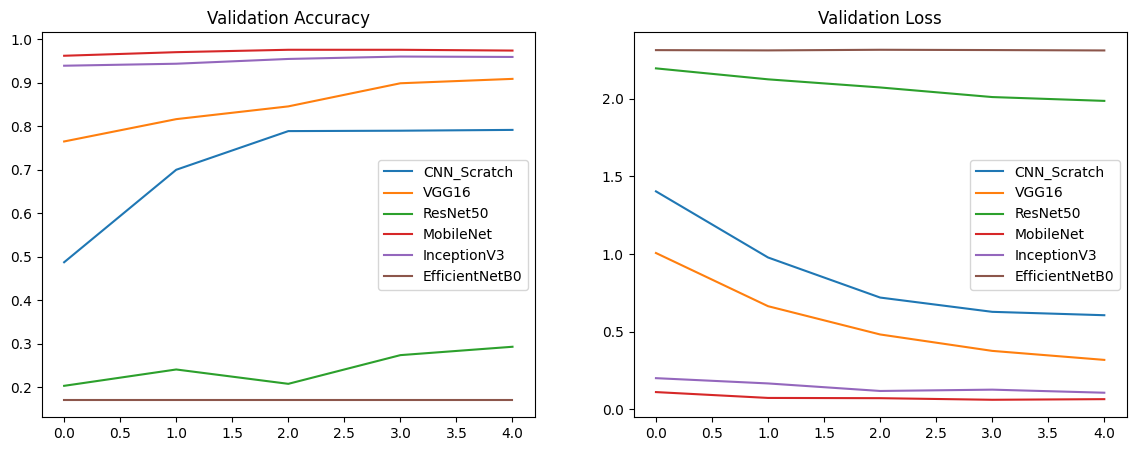

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step


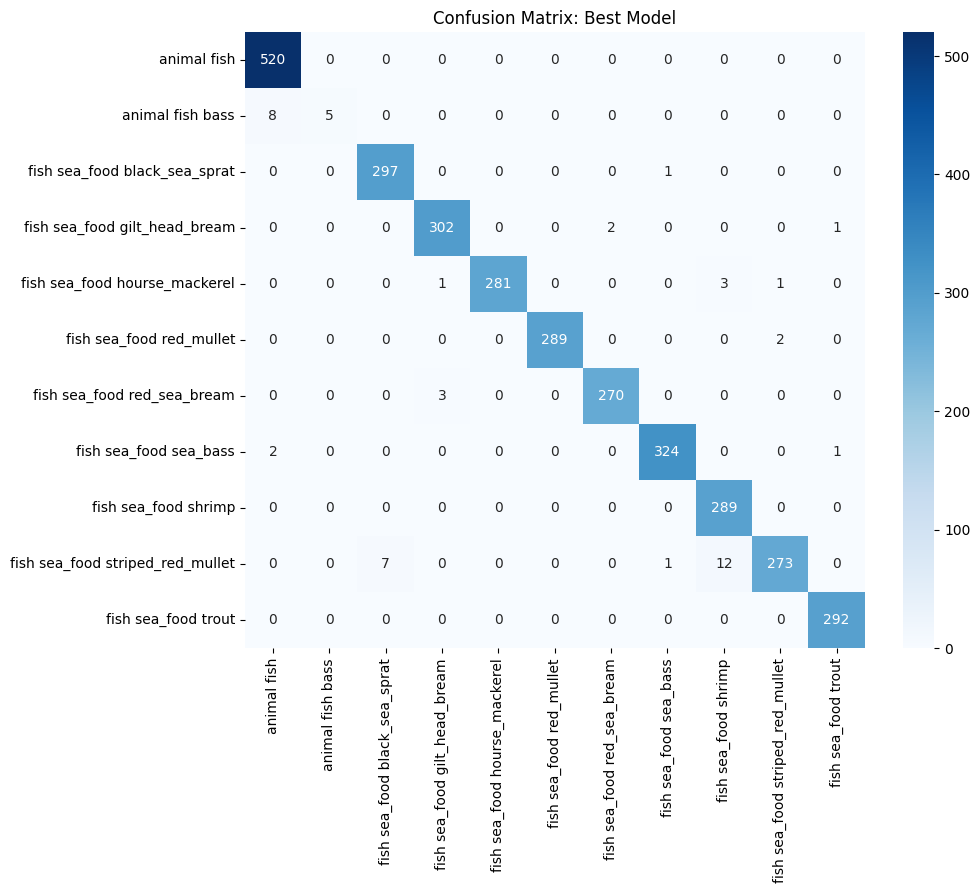

In [7]:
# 1. Visualization of History
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for name in model_names:
    plt.plot(histories[name].history['val_accuracy'], label=name)
plt.title('Validation Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
for name in model_names:
    plt.plot(histories[name].history['val_loss'], label=name)
plt.title('Validation Loss'); plt.legend()
plt.show()

# 2. Confusion Matrix for the Best Model
best_m = tf.keras.models.load_model('best_fish_model.h5')
test_gen.reset()
final_preds = np.argmax(best_m.predict(test_gen), axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_gen.classes, final_preds),
            annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix: Best Model')
plt.show()

In [8]:
!pip install -q streamlit pyngrok tensorflow pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 122.0 MB/s eta 0:00:00


In [9]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from PIL import Image

# Configuration
MODEL_PATH = "/content/best_fish_model.h5"
TRAIN_DIR = "/content/fish_project/images/data/train"
TARGET_SIZE = (224, 224)

# Load Class Names safely
if os.path.exists(TRAIN_DIR):
    class_names = sorted(os.listdir(TRAIN_DIR))
else:
    st.warning("Training directory not found. Using default placeholder classes.")
    class_names = ["Species_A", "Species_B", "Species_C"] # Fallback

# Load Model safely
@st.cache_resource
def load_fish_model():
    if os.path.exists(MODEL_PATH):
        return tf.keras.models.load_model(MODEL_PATH)
    return None

model = load_fish_model()

def preprocess_image(img):
    img = img.resize(TARGET_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

st.set_page_config(page_title="Fish Species Classification", page_icon="🐟")
st.title("🐟 Fish Species Classification")
st.write("Upload an image to classify the fish species.")

if model is None:
    st.error(f"Model file not found at {MODEL_PATH}. Please upload the model to Colab.")
else:
    uploaded_file = st.file_uploader("Choose an image", type=['jpg', 'jpeg', 'png'])

    if uploaded_file is not None:
        img = Image.open(uploaded_file).convert("RGB")
        st.image(img, caption="Uploaded Image", use_container_width=True)

        if st.button("🔍 Classify Fish"):
            with st.spinner("Analyzing..."):
                img_array = preprocess_image(img)
                prediction = model.predict(img_array)

                idx = np.argmax(prediction)
                predicted_class = class_names[idx] if idx < len(class_names) else "Unknown"
                confidence = np.max(prediction) * 100

                st.success(f"**Predicted Class:** {predicted_class}")
                st.info(f"**Confidence:** {confidence:.2f}%")

Writing app.py


In [10]:
import os
from pyngrok import ngrok
import subprocess
import time

# 1. Set your Auth Token (Keep this private!)
NGROK_AUTH_TOKEN = "31Md7ezKXXvOuYU4Zci8vLGILqF_5yDW6JTfSnsnAzbaLhbz"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# 2. Terminate any existing tunnels
ngrok.kill()

# 3. Run Streamlit in the background
# We use 'app.py' instead of the colab_kernel_launcher
port = 8501
process = subprocess.Popen([
    "streamlit", "run", "app.py",
    "--server.port", str(port),
    "--server.address", "0.0.0.0",
    "--server.headless", "true"
])

# Wait for the server to start
time.sleep(5)

# 4. Create the Tunnel
try:
    public_url = ngrok.connect(port)
    print(f"\n✅ Success! Access your app here:\n{public_url.public_url}")
except Exception as e:
    print(f"❌ Error connecting ngrok: {e}")


✅ Success! Access your app here:
https://7c0b329a1c2d.ngrok-free.app
